# Vehicle Routing Problem

 - **QOSF Mentorship Program - Spring 2021**
 - **Mentor: Dr. Vesselin Gueorguiev**
 - **Mentees: Aniket Sanjay Sinha, Avneesh Verma, Shantom Kumar Borah**

## Introduction
This document explores various formulations and algorithms involved in solving the Vehicle Routing Problem (VRP) via Quadratic Unconstrained Binary Optimization (QUBO) on a quantum computer. For the solution of QUBOs on a quantum computer, currently available gate-based quantum computers are only able to solve the simplest versions of the problem, due to a very limited number of qubits. In this document, we use D-Wave's quantum computers based on Quantum Annealing to solve the Vehicle Routing Problem. D-Wave's quantum computers have access to a signifiantly larger number of qubits (more than 5000 for the newest Advantage Systems) and enable the solution of significantly larger versions of the VRP. The contents of this document are organized as follows:

 - *Problem Statement*
 - *Core Solvers*
 - *Qubit Complexity Comparison*
 - *QUBO Cost and Execution Times*

## Problem Statement
The Vehicle Routing Problem (VRP) may be thought of as a generalization of the Travelling Salesman Problem (TSP) with $M$ salesmen instead of one. Specifically, we have depot with a certain amount of goods that need to be delivered to a number of clients located at different places. The depot has access to $M$ delivery vehicles to make these deliveries. Let $N$ be the number of clients. Consider a fully connected graph of $N + 1$ nodes with the depot being the node $0$ and the variouis clients being nodes $\{1, 2, \dots N\}$. Every edge $(i, j)$ of this fully connected graph represents the cost of moving from node $i$ to node $j$. This cost could be the time taken, the distance covered or anything at all that needs to be minimized. In our case, we have chosen it to be distance. The objective is to simply find the optimal route through this graph, for each vehicle, so that all deliveries are made with minimum cost. We use the following notation for the rest of this document:

 - *$N$: No. of clients, excluding the depot*
 - *$M$: No. of vehicles*
 - *$C_{ij}$: Cost of moving from node $i$ to node $j$*

**Objective**: Find the optimal route for all $M$ vehicles covering all $N$ routes so that the total cost of this route is minimized.

## Core Solvers

In this project, we have investigated six different formulations of the VRP for solving via quantum annealing. Each of these have their own advantages and disadvantages. These six solvers are listed below:

 - *Full QUBO Solver*
 - *Average Partitioning Solver*
 - *Route Activation Solver*
 - *Qiskit Native Solver*
 - *Clustered TSP Solver*
 - *Solution Partitioning Solver*

In this section, we shall outline each of these solvers and demonstrate their solution using D-Wave's Leap Hybrid Solvers. For each solver, we outline how the problem is represented in QUBO form below, along with the objective function to be minimized and the various associated constraints, followed by an example usage of the code. We begin by importing the necessary files and creating a test VRP instance to demonstrate the working of each of these solvers.

In [1]:
import numpy as np
import utility

from full_qubo_solver import FullQuboSolver
from average_partition_solver import AveragePartitionSolver
from qiskit_native_solver import QiskitNativeSolver
from route_activation_solver import RouteActivationSolver
from clustered_tsp_solver import ClusteredTspSolver
from solution_partition_solver import SolutionPartitionSolver

In [2]:
n = 5
m = 2
seed = 1543

In [3]:
instance, xc, yc = utility.generate_vrp_instance(n, seed)

## Full Qubo Solver (FQS)

***Representation***

$x_{i,j,k} = 1$ if $i^{th}$ vehicle is in $j^{th}$ node at the $k^{th}$ timestep.

$$i \in \{1, 2, \dots M\}; \; j \in \{0, 1, \dots N\}; \; k \in \{1, 2, \dots N\}$$

***Objective Function***

$$C = \sum_{m=1}^M \sum_{n=1}^N C_{0,n} x_{m,n,1} + \sum_{m=1}^M \sum_{n=1}^N C_{n,0} x_{m,n,N} + \sum_{m=1}^M \sum_{n=1}^{N-1} \sum_{i=0}^{N} \sum_{j=0}^{N} C_{i,j} x_{m,i,n} x_{m,j,n+1}$$

Here, the first term represents the cost of moving from the depot to the first visited client for each vehicle, the second term represents the cost of moving from the last visited client to the depot for each vehicle, and the third term represents the costs at the intermediate nodes.

***Constraints***

 - Every node (other than the depot) is served by exactly one vehicle at exactly one time instant.

$$\sum_{i=1}^M \sum_{j=1}^N x_{i,k,j} = 1 \;\;\forall k$$

 - A vehicle can be at only one place at any given timestep.

$$\sum_{k=0}^N x_{i,k,j} = 1 \;\;\forall i, j$$

***Qubit Complexity***

 - No. of Logical Variables: $MN(N+1)$
 - Best Case: $N(N+1)$
 - Worst Case: $N^2(N+1)$

![](images/fqs_complexity.png)

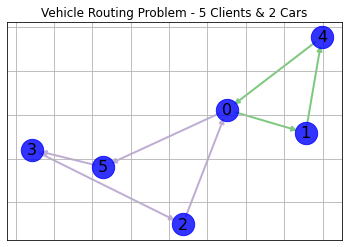

In [4]:
fqs = FullQuboSolver(n, m, instance)
fqs.solve(solver='leap')
fqs.visualize(xc, yc)

## Average Partitioning Solver (APS)

***Representation***

$x_{i,j,k} = 1$ if $i^{th}$ vehicle is in $j^{th}$ node at the $k^{th}$ timestep.

$$i \in \{1, 2, \dots M\}; \; j \in \{0, 1, \dots N\}; \; k \in \{1, 2, \dots T\}$$

The maximum timestep $T$ is evaluated as follows

$$T = \min\{N, \frac{N}{M} + L\}$$

Here, $L$ is a solver parameter called *Limit Radius* and naturally, we round up the above $T$ to the next integer.

***Objective Function***

$$C = \sum_{m=1}^M \sum_{n=1}^N C_{0,n} x_{m,n,1} + \sum_{m=1}^M \sum_{n=1}^N C_{n,0} x_{m,n,T} + \sum_{m=1}^M \sum_{n=1}^{T-1} \sum_{i=0}^{N} \sum_{j=0}^{N} C_{i,j} x_{m,i,n} x_{m,j,n+1}$$

Here, the first term represents the cost of moving from the depot to the first visited client for each vehicle, the second term represents the cost of moving from the last visited client to the depot for each vehicle, and the third term represents the costs at the intermediate nodes.

***Constraints***

 - Every node (other than the depot) is served by exactly one vehicle at exactly one time instant.

$$\sum_{i=1}^M \sum_{j=1}^T x_{i,k,j} = 1 \;\;\forall k$$

 - A vehicle can be at only one place at any given timestep.

$$\sum_{k=0}^N x_{i,k,j} = 1 \;\;\forall i, j$$

***Qubit Complexity***

 - No. of Logical Variables: $MT(N+1)$
 - Best Case: $N(N+1)$
 - Worst Case: $N^2(N+1)$

![](images/aps_complexity.png)

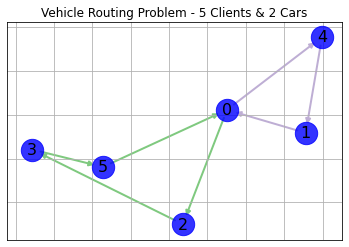

In [5]:
aps = AveragePartitionSolver(n, m, instance)
aps.solve(solver='leap')
aps.visualize(xc, yc)

## Route Activation Solver (RAS)

***Representation***

$x_{i,j} = 1$ if the route from the $i^{th}$ node to the $j^{th}$ node is traversed by any vehicle at any time.

$$i \in \{0, 1, \dots N\}; \; j \in \{0, 1, \dots N\}; \; i \neq j$$

***Objective Function***

$$C = \sum_{i=0}^N \sum_{j=0}^N C_{i,j} x_{i,j}$$

***Constraints***

 - Each node (other than the depot) has exactly $1$ outgoing active edge and exactly $1$ incoming active edge.

$$\sum_{j\neq i,j=0}^N x_{i,j} = 1 \;\;\forall i$$
$$\sum_{i\neq j,i=0}^N x_{i,j} = 1 \;\;\forall j$$

 - The depot has exactly $M$ outgoing and $M$ incoming connections.

$$\sum_{j=1}^N x_{0,j} = M $$
$$\sum_{j=1}^N x_{j,0} = M $$

***Qubit Complexity***

 - No. of Logical Variables: $N(N+1)$
 - Best Case: $N(N+1)$
 - Worst Case: $N(N+1)$

![](images/ras_complexity.png)

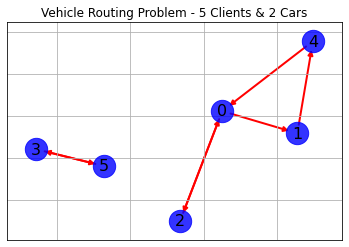

In [6]:
ras = RouteActivationSolver(n, m, instance)
ras.solve(solver='leap')
ras.visualize(xc, yc)

## Qiskit Native Solver (QNS)

***Representation***

$x_{i,j} = 1$ if the route from the $i^{th}$ node to the $j^{th}$ node is traversed by any vehicle at any time.

$$i \in \{0, 1, \dots N\}; \; j \in \{0, 1, \dots N\}; \; i \neq j$$

***Objective Function***

$$C = \sum_{i=0}^N \sum_{j=0}^N C_{i,j} x_{i,j}$$

***Constraints***

 - Each node (other than the depot) has exactly $1$ outgoing active edge and exactly $1$ incoming active edge.

$$\sum_{j\neq i,j=0}^N x_{i,j} = 1 \;\;\forall i$$
$$\sum_{i\neq j,i=0}^N x_{i,j} = 1 \;\;\forall j$$

 - The depot has exactly $M$ outgoing and $M$ incoming connections.

$$\sum_{j=1}^N x_{0,j} = M $$
$$\sum_{j=1}^N x_{j,0} = M $$

 - DFJ Constraints for subtour elimination. Basically consider every possible subtour loop and eliminate them individually. Very inefficient.

$$\sum_{i, j \in S, i \neq j} x_{i,j} \leq |S| - 1 \;\;\forall S$$

Here, $S$ represents a set of nodes excluding the depot that can form a loop and $|S|$ is the number of nodes in the loop $S$. The above constraint needs to be enforced for all possible loops $S$, which is what makes it so inefficient.

***Qubit Complexity***

 - No. of Logical Variables: $N(N+1)$
 - Best Case: $N(N+1)$
 - Worst Case: $N(N+1)$

![](images/qns_complexity.png)

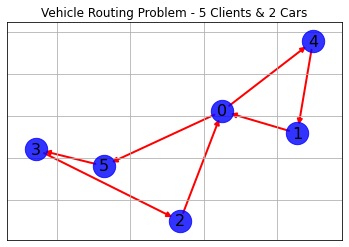

In [7]:
qns = QiskitNativeSolver(n, m, instance)
qns.solve(solver='leap')
qns.visualize(xc, yc)

## Clustered Tsp Solver (CTS)

***Algorithm***

Use a multilevel maxcut with $M$ partitions to cluster the nodes into $M$ clsuters. Assign each cluster to a different vehicle and solve Travelling Salesman for each. Clustering is done using D-Wave's Leap Hybrid DQM Solvers. Below we show the formulation for TSP with $P$ nodes. This TSP is to be repeated for each cluster.

***Representation***

$x_{i,j} = 1$ if the salesman is at the $i^{th}$ node at the $j^{th}$ timestep.

$$i \in \{1, \dots P\}; \; j \in \{1, \dots P\}$$

***Objective Function***

$$C = \sum_{n=1}^P C_{0,n} x_{n,1} + \sum_{n=1}^P C_{n,0} x_{n,P} + \sum_{n=1}^{N-1} \sum_{i=1}^{N} \sum_{j=1}^{N} C_{i,j} x_{i,n} x_{j,n+1}$$

Here, the first term represents the cost of moving from the depot to the first visited client for each vehicle, the second term represents the cost of moving from the last visited client to the depot for each vehicle, and the third term represents the costs at the intermediate nodes.

***Constraints***

 - Every node is served at only one time.

$$\sum_{j=1}^P x_{i,j} = 1 \;\;\forall i$$

 - The vehicle can be at only one place at a given time

$$\sum_{i=1}^P x_{i,j} = 1 \;\;\forall j$$

***Qubit Complexity***

 - No. of Logical Variables: $MN + \frac{N^2}{M}$
 - Best Case: $2N\sqrt{N}$
 - Worst Case: $N(N+1)$

![](images/cts_complexity.png)

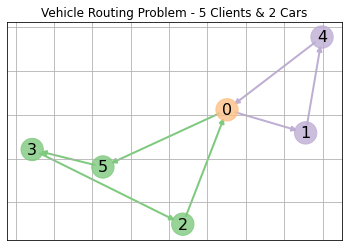

In [8]:
cts = ClusteredTspSolver(n, m, instance)
cts.solve(solver='leap')
cts.visualize(xc, yc)

## Solution Partitioning Solver (SPS)

***Algorithm***

Assume a single vehicle and solve the TSP for the problem. Then cut the TSP solution at $M-1$ points to generate $M$ routes for $M$ vehicles. While selecting the cuts, out of a total possible $N-1$ choices, choose the $M-1$ cuts that would minimize the extra cost incurred. Below, we outline the TSP formulation used.

***Representation***

$x_{i,j} = 1$ if the salesman is at the $i^{th}$ node at the $j^{th}$ timestep.

$$i \in \{1, \dots P\}; \; j \in \{1, \dots P\}$$

***Objective Function***

$$C = \sum_{n=1}^P C_{0,n} x_{n,1} + \sum_{n=1}^P C_{n,0} x_{n,P} + \sum_{n=1}^{N-1} \sum_{i=1}^{N} \sum_{j=1}^{N} C_{i,j} x_{i,n} x_{j,n+1}$$

Here, the first term represents the cost of moving from the depot to the first visited client for each vehicle, the second term represents the cost of moving from the last visited client to the depot for each vehicle, and the third term represents the costs at the intermediate nodes.

***Constraints***

 - Every node is served at only one time.

$$\sum_{j=1}^P x_{i,j} = 1 \;\;\forall i$$

 - The vehicle can be at only one place at a given time

$$\sum_{i=1}^P x_{i,j} = 1 \;\;\forall j$$

***Qubit Complexity***

 - No. of Logical Variables: $N^2$
 - Best Case: $N^2$
 - Worst Case: $N^2$

![](images/sps_complexity.png)

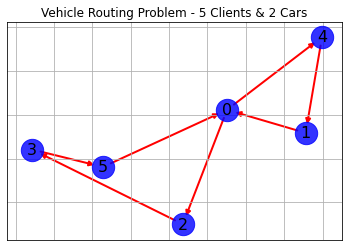

In [9]:
sps = SolutionPartitionSolver(n, m, instance)
sps.solve(solver='leap')
sps.visualize(xc, yc)

## Qubit Complexity

By Qubit Complexity of a solver, we refer to the number of logical variables in the Quadratic Program for the associated solver. We have already specified the number of variables required for each Solver in the previous section. We tabulate this data below.

| Solver | Best Case Complexity | Worst Case Complexity |
| :-: | :-: | :-: |
| ***FQS*** | $N(N + 1)$ | $N^2(N + 1)$ |
| ***APS*** | $N(N + 1)$ | $N^2(N + 1)$ |
| ***RAS*** | $N(N + 1)$ | $N(N + 1)$ |
| ***QNS*** | $N(N + 1)$ | $N(N + 1)$ |
| ***CTS*** | $2N\sqrt{N}$ | $N(N + 1)$ |
| ***SPS*** | $N^2$ | $N^2$ |

For comparison, we plot the best and worst case qubit complexities for the solvers below:
![](images/qubit_complexity.png)

## QUBO Cost and Execution Times
In this section, we show how we may evaluate the performance of the various solvers by monitoring the exection times and optimized cost. A more detailed performance analysis may be found in the Jupyter Notebooks inside the **'QOSF-cohort3/vehicle_routing/Performance_Comparisons/
'** folder of the github repository.

### Optimized Cost

In [10]:
vrp_list = [fqs, aps, ras, qns, cts, sps]
solver_types = ['FQS', 'APS', 'RAS', 'QNS', 'CTS', 'SPS']
for i, vrp in enumerate(vrp_list):
    print(f'{solver_types[i]} - Optimized Cost: {vrp.evaluate_vrp_cost()}')

FQS - Optimized Cost: 45.994911845526076
APS - Optimized Cost: 45.994911845526076
RAS - Optimized Cost: 25.41893410233024
QNS - Optimized Cost: 45.97415357583668
CTS - Optimized Cost: 45.99419584261341
SPS - Optimized Cost: 45.99428951003456


### QUBO Build Times

In [11]:
qubo_time = [vrp.timing['qubo_build_time'] for vrp in vrp_list]
for i in range(len(vrp_list)):
    print(f'{solver_types[i]} - Classical QUBO Build Time: {qubo_time[i]} us')

FQS - Classical QUBO Build Time: 223975.65841674805 us
APS - Classical QUBO Build Time: 343986.27281188965 us
RAS - Classical QUBO Build Time: 110995.76950073242 us
QNS - Classical QUBO Build Time: 461000.6809234619 us
CTS - Classical QUBO Build Time: 44999.122619628906 us
SPS - Classical QUBO Build Time: 139993.90602111816 us


### D-Wave QPU Access Times

In [12]:
qpu_time = [vrp.timing['qpu_access_time'] for vrp in vrp_list]
qpu_time[4] += cts.timing['clustering_time']['qpu_access_time']
for i in range(len(vrp_list)):
    print(f'{solver_types[i]} - QPU Access Time: {qpu_time[i]} us')

FQS - QPU Access Time: 46680 us
APS - QPU Access Time: 70023 us
RAS - QPU Access Time: 94983 us
QNS - QPU Access Time: 73041 us
CTS - QPU Access Time: 227030 us
SPS - QPU Access Time: 109557 us


## Capacitated Solvers

The github repository also includes a set of solvers for solving the capacitated vehicle routing problem. An example of this, the Capacitated SPS, is shown below. All other solvers, other than QNS, also have their capacitated versions, which are accessed in a similar manner. It is to be noted that almost all all capacitated solvers are in general, quite poor-performing in comparison to the basic solvers, largely due to the additional constraints introduced. The Capacitated SPS, is basically the only algorithm that seems to provide a decent performance in this case.

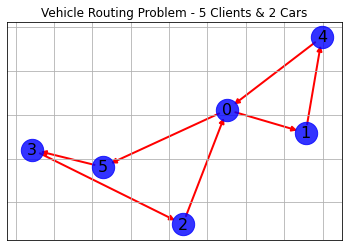

In [13]:
from solution_partition_solver import CapcSolutionPartitionSolver

cap = 10
dem = [1, 2, 3, 4, 5]
sps = CapcSolutionPartitionSolver(n, m, instance, cap, dem)
sps.solve(solver='leap')
sps.visualize(xc, yc)

## Conclusion
In this document, we have explored the formulations of six different solvers for the Vehicle Routing Problem and have provided the example code for their usage. A more detailed performance analysis of each of these as well as comparisons against classical CPLEX solvers may be found in the **'QOSF-cohort3/vehicle_routing/Performance_Comparisons/
'** folder of the github repository.